# Gesture Recognition

In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Problem Statement
Imagine we are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. We want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie
 

Each video is a sequence of 30 frames (or images).



In [2]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [3]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

2.16.1


In [4]:
project_folder = "Project_data"

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
num_classes = 5  #number of softmax classes

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder + '/' + 'train'
val_path = project_folder + '/' + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Common Utils

Common utility to plot loss and accuracy

In [7]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Common utility to calculate steps

In [8]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

Common utility for callbacks

In [9]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. we have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:1047: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(
/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_62502/2963303598.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(project_folder + '/' + 'train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_62502/2963303598.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v

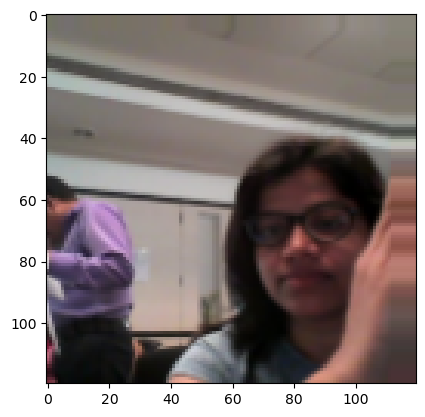

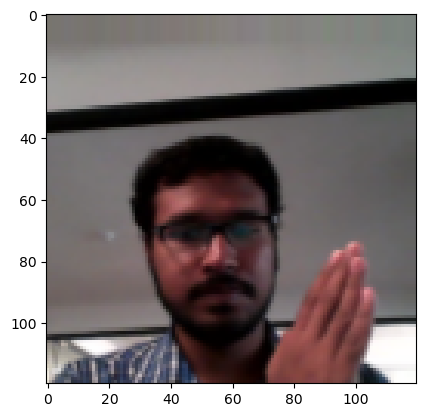

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
# image1 = imageio.imread("/kaggle/input/gesture-recognition/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png")
image1 = imageio.imread(project_folder + '/' + 'train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
#160 by 120
# image2 = imageio.imread("/kaggle/input/gesture-recognition/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00015.png")
image2 = imageio.imread(project_folder + '/' + 'val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00015.png')
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here we make the model using different functionalities that Keras provides. We will use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. We will Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

### Conv3d Models

In [11]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Model 1: Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [12]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-01 00:02:11.090396: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-01 00:02:11.090412: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-01 00:02:11.090417: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-01 00:02:11.090432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-01 00:02:11.090440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/ta

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20


2024-04-01 00:02:14.594588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


65/67 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - categorical_accuracy: 0.3038 - loss: 2.0533

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3070 - loss: 2.0432
Epoch 1: val_loss improved from inf to 6.72364, saving model to model_conv3D_1_2024-04-0100_02_10.957255/model-00001-1.70684-0.41327-6.72364-0.26000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - categorical_accuracy: 0.3086 - loss: 2.0382 - val_categorical_accuracy: 0.2600 - val_loss: 6.7236 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5354 - loss: 1.3827
Epoch 2: val_loss improved from 6.72364 to 3.54072, saving model to model_conv3D_1_2024-04-0100_02_10.957255/model-00002-1.32626-0.53243-3.54072-0.32000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - categorical_accuracy: 0.5353 - loss: 1.3819 - val_categorical_accuracy: 0.3200 - val_loss: 3.5407 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6473 - loss: 0.9706
Epoch 3: val_loss improved from 3.54072 to 3.34287, saving model to model_conv3D_1_2

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


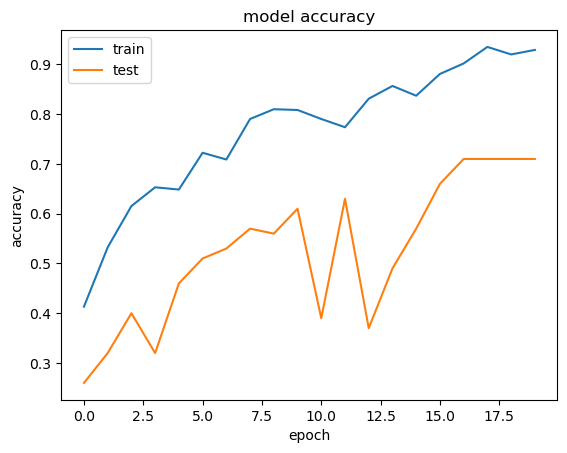

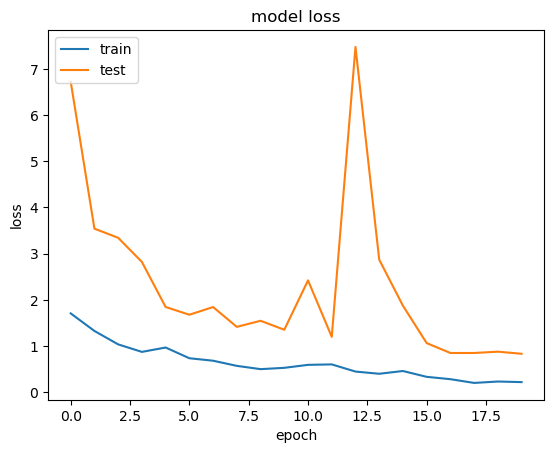

In [15]:
plot_loss_accuracy(history)

#### Model 2: Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [16]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - categorical_accuracy: 0.3806 - loss: 1.7745

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3824 - loss: 1.7694
Epoch 1: val_loss improved from inf to 1.85274, saving model to model_conv3D_2_2024-04-0100_02_10.957255/model-00001-1.60359-0.43891-1.85274-0.17000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - categorical_accuracy: 0.3832 - loss: 1.7669 - val_categorical_accuracy: 0.1700 - val_loss: 1.8527 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5306 - loss: 1.1845
Epoch 2: val_loss did not improve from 1.85274
67/67 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - categorical_accuracy: 0.5311 - loss: 1.1832 - val_categorical_accuracy: 0.3100 - val_loss: 2.9712 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6277 - loss: 1.0005
Epoch 3: val_loss did not improve from 1.85274
67/67 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - categorical_accuracy: 0.6276 - loss: 1.0009 - val_categorical_accuracy: 0.3200 - val_loss: 2.1508 - learnin

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


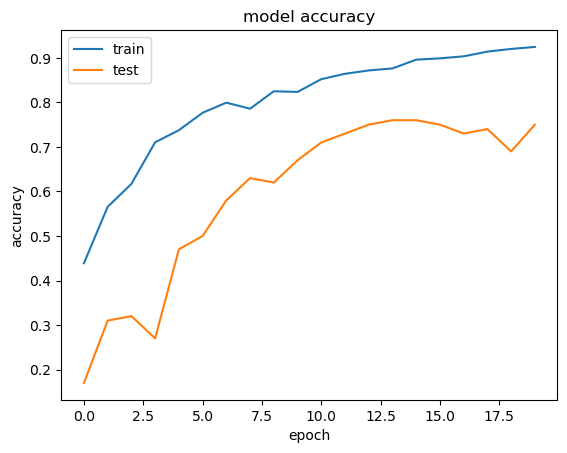

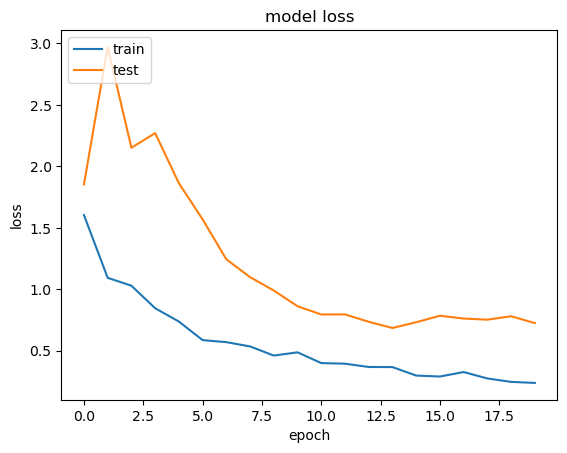

In [19]:
plot_loss_accuracy(history)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

#### Model 3: Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [20]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 20, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 20, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 10, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 10, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 10, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 5, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 5, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 5, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 2, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 2, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 2, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,604,933 (13.75 MB)

 Trainable params: 3,603,685 (13.75 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - categorical_accuracy: 0.3934 - loss: 1.7564 

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3955 - loss: 1.7489
Epoch 1: val_loss improved from inf to 2.02446, saving model to model_conv3D_3_2024-04-0100_02_10.957255/model-00001-1.50591-0.46305-2.02446-0.25000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - categorical_accuracy: 0.3965 - loss: 1.7453 - val_categorical_accuracy: 0.2500 - val_loss: 2.0245 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5772 - loss: 1.1081
Epoch 2: val_loss did not improve from 2.02446
67/67 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - categorical_accuracy: 0.5775 - loss: 1.1074 - val_categorical_accuracy: 0.2800 - val_loss: 2.9417 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7058 - loss: 0.7798
Epoch 3: val_loss did not improve from 2.02446
67/67 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - categorical_accuracy: 0.7053 - loss: 0.7807 - val_categorical_accuracy: 0.2700 - val_loss: 3.7721 - learnin

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


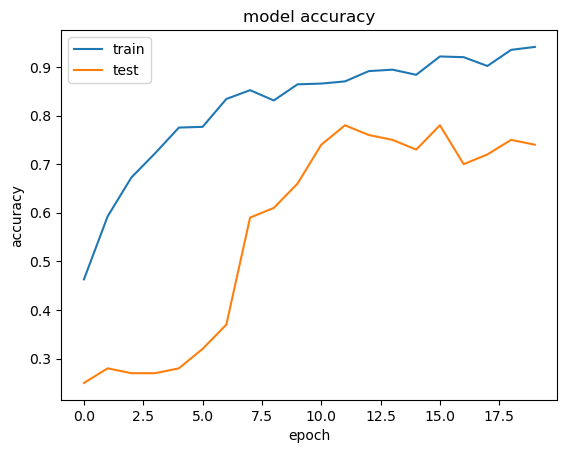

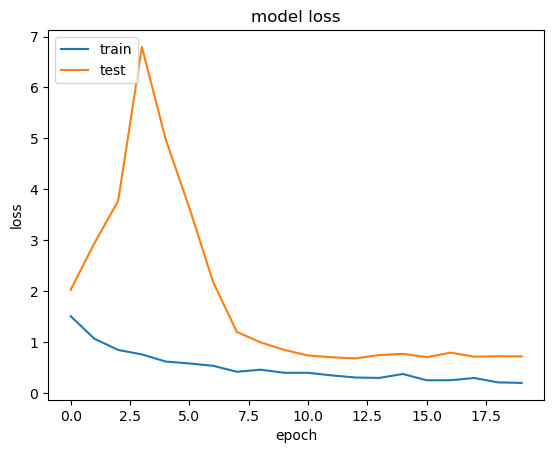

In [24]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [25]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


In [16]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
65/67 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - categorical_accuracy: 0.3810 - loss: 1.7750

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3821 - loss: 1.7713
Epoch 1: val_loss improved from inf to 2.07958, saving model to model_conv3D_4_2024-04-0100_02_10.957255/model-00001-1.64449-0.42081-2.07958-0.24000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - categorical_accuracy: 0.3827 - loss: 1.7695 - val_categorical_accuracy: 0.2400 - val_loss: 2.0796 - learning_rate: 0.0010
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5785 - loss: 1.1998
Epoch 2: val_loss did not improve from 2.07958
67/67 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - categorical_accuracy: 0.5783 - loss: 1.1994 - val_categorical_accuracy: 0.2200 - val_loss: 2.2879 - learning_rate: 0.0010
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6156 - loss: 1.0521
Epoch 3: val_loss improved from 2.07958 to 2.00549, saving model to model_conv3D_4_2024-04-0100_02_10.957255/model-00003-1.10519-0.58371-2.00549-0.33000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/st

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


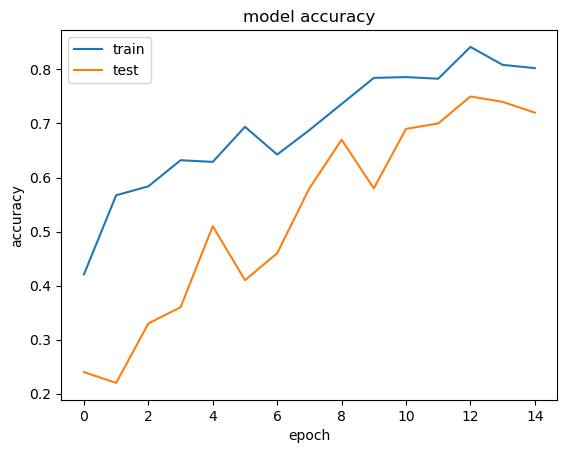

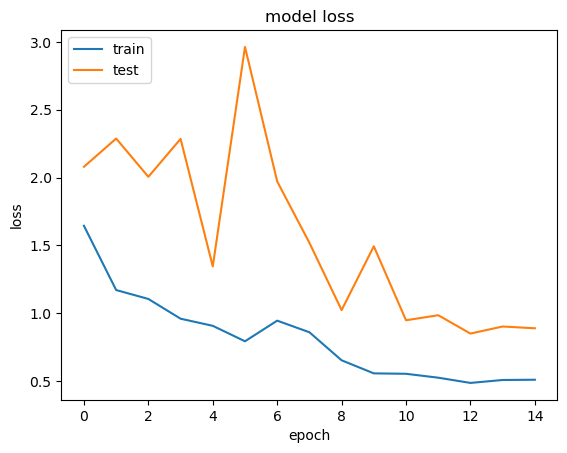

In [28]:
plot_loss_accuracy(history)

#### Model 5: Conv 3D Model with 30 frames per video (8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [29]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)              │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_18 (Conv3D)              │ (None, 7, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 3, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 3, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 911,973 (3.48 MB)

 Trainable params: 910,965 (3.48 MB)

 Non-trainable params: 1,008 (3.94 KB)

None


In [30]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [31]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
64/67 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - categorical_accuracy: 0.3599 - loss: 1.7656

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3636 - loss: 1.7571
Epoch 1: val_loss improved from inf to 2.80142, saving model to model_conv3D_5_2024-04-0100_02_10.957255/model-00001-1.57021-0.44344-2.80142-0.20000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - categorical_accuracy: 0.3648 - loss: 1.7543 - val_categorical_accuracy: 0.2000 - val_loss: 2.8014 - learning_rate: 0.0010
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5911 - loss: 1.0551
Epoch 2: val_loss improved from 2.80142 to 2.21969, saving model to model_conv3D_5_2024-04-0100_02_10.957255/model-00002-1.05132-0.58824-2.21969-0.41000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - categorical_accuracy: 0.5911 - loss: 1.0551 - val_categorical_accuracy: 0.4100 - val_loss: 2.2197 - learning_rate: 0.0010
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6900 - loss: 0.8085
Epoch 3: val_loss did not improve from 2.21969
67/67 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/st

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


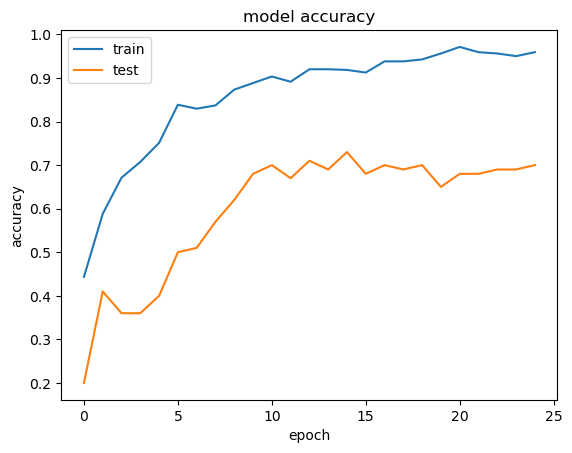

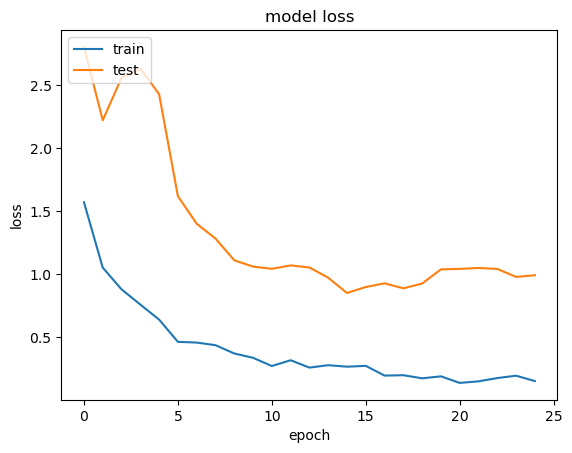

In [32]:
plot_loss_accuracy(history)

#### Model 6: Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [33]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 20
# num_frames per video = 20


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)              │ (None, 20, 120, 120,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 20, 120, 120,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 20, 120, 120,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_21 (Conv3D)              │ (None, 10, 60, 60, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 10, 60, 60, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 10, 60, 60, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_22 (Conv3D)              │ (None, 5, 30, 30, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 5, 30, 30, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 5, 30, 30, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 2, 15, 15, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 2, 15, 15, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 2, 15, 15, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 1, 7, 7, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,790,149 (10.64 MB)

 Trainable params: 2,788,677 (10.64 MB)

 Non-trainable params: 1,472 (5.75 KB)

None


In [34]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [35]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
32/34 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - categorical_accuracy: 0.4028 - loss: 1.6642

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4065 - loss: 1.6520
Epoch 1: val_loss improved from inf to 10.63336, saving model to model_conv3D_6_2024-04-0100_02_10.957255/model-00001-1.45300-0.46456-10.63336-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 288s 8s/step - categorical_accuracy: 0.4081 - loss: 1.6463 - val_categorical_accuracy: 0.2400 - val_loss: 10.6334 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5782 - loss: 1.1294
Epoch 2: val_loss improved from 10.63336 to 1.47409, saving model to model_conv3D_6_2024-04-0100_02_10.957255/model-00002-1.09941-0.57919-1.47409-0.40000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 276s 8s/step - categorical_accuracy: 0.5782 - loss: 1.1285 - val_categorical_accuracy: 0.4000 - val_loss: 1.4741 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5891 - loss: 1.0567
Epoch 3: val_loss did not improve from 1.47409
34/34 ━━━━━━━━━━━━━━━━━━━━ 272s 8

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


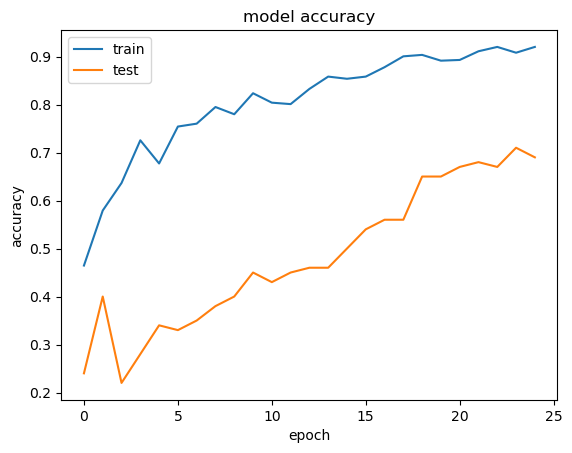

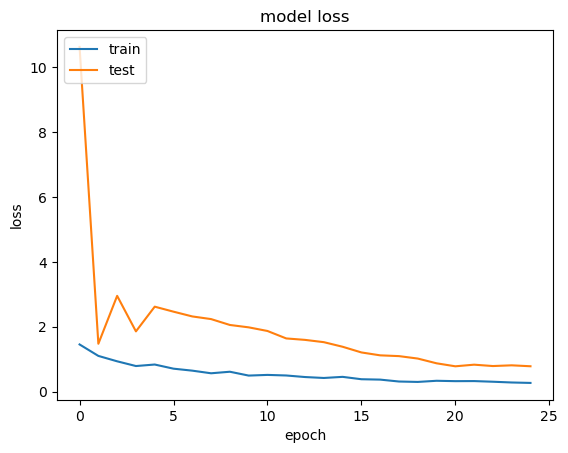

In [36]:
plot_loss_accuracy(history)

#### Model 7: Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [37]:
#write your model here
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [38]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 5
# num_frames per video = 30


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)              │ (None, 30, 120, 120,   │         6,016 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_25 (MaxPooling3D) │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_26 (Conv3D)              │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_27 (Conv3D)              │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,938,469 (7.39 MB)

 Trainable params: 1,937,221 (7.39 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [39]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [40]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
131/133 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - categorical_accuracy: 0.3830 - loss: 1.8661

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3833 - loss: 1.8637
Epoch 1: val_loss improved from inf to 7.93461, saving model to model_conv3D_9_2024-04-0100_02_10.957255/model-00001-1.70849-0.39668-7.93461-0.29000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - categorical_accuracy: 0.3834 - loss: 1.8626 - val_categorical_accuracy: 0.2900 - val_loss: 7.9346 - learning_rate: 0.0010
Epoch 2/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3635 - loss: 1.6067
Epoch 2: val_loss improved from 7.93461 to 1.85424, saving model to model_conv3D_9_2024-04-0100_02_10.957255/model-00002-1.66025-0.37858-1.85424-0.39000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - categorical_accuracy: 0.3636 - loss: 1.6071 - val_categorical_accuracy: 0.3900 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 3/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4245 - loss: 1.4947
Epoch 3: val_loss improved from 1.85424 to 1.46734, saving model to model_

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


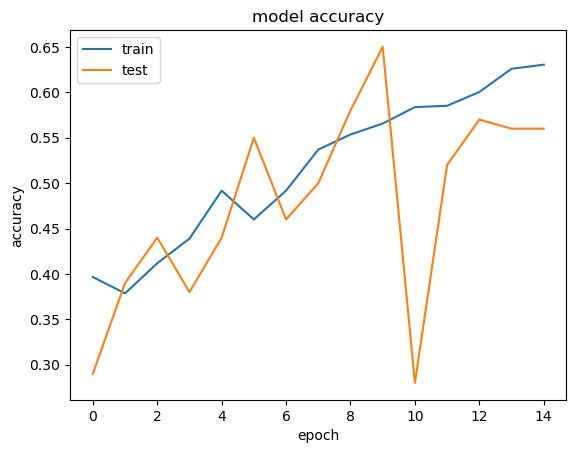

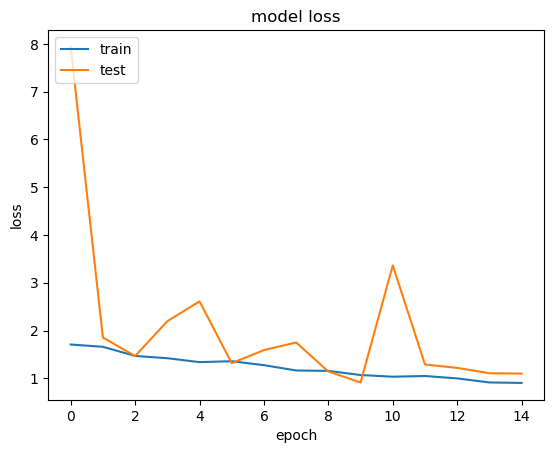

In [41]:
plot_loss_accuracy(history)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [13]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Model 8: Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [43]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2976428483.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Number of layers in the pretrained mobilenet model:  86


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [44]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [45]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - categorical_accuracy: 0.2441 - loss: 1.7634

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_40322/2963303598.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2443 - loss: 1.7615
Epoch 1: val_loss improved from inf to 1.60953, saving model to model_retrain_mobilenet_gru_2024-04-0100_02_10.957255/model-00001-1.69930-0.25038-1.60953-0.18000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1058s 12s/step - categorical_accuracy: 0.2444 - loss: 1.7606 - val_categorical_accuracy: 0.1800 - val_loss: 1.6095 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.1884 - loss: 1.6096
Epoch 2: val_loss improved from 1.60953 to 1.60912, saving model to model_retrain_mobilenet_gru_2024-04-0100_02_10.957255/model-00002-1.60956-0.20513-1.60912-0.18000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - categorical_accuracy: 0.1887 - loss: 1.6096 - val_categorical_accuracy: 0.1800 - val_loss: 1.6091 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.1950 - loss: 1.6086
Epoch 3: val_loss improved from 1.60912 to 1.60900, savi

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


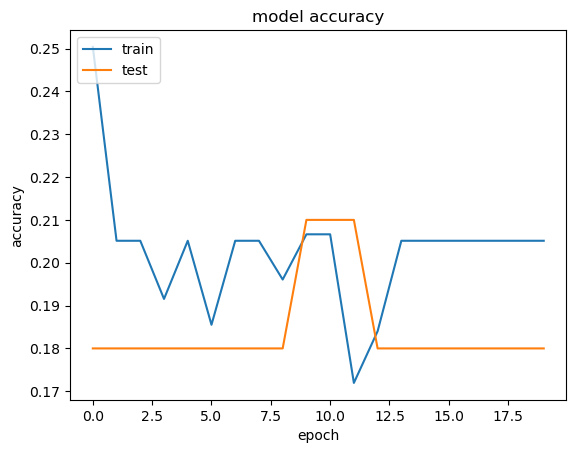

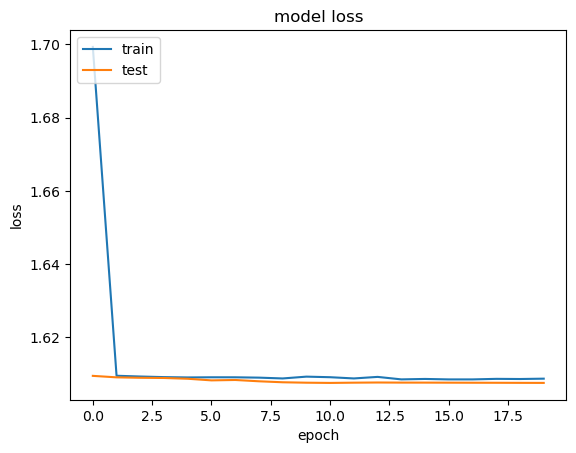

In [46]:
plot_loss_accuracy(history)

#### Model 9: Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [14]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 15
# batch size = 10
# num frames per video = 30


/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_62502/2976428483.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
2024-04-01 20:30:56.641201: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-01 20:30:56.641280: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-01 20:30:56.641299: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-01 20:30:56.641360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-01 20:30:56.641401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow devi

Number of layers in the pretrained mobilenet model:  86


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [48]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [17]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_62502/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15


2024-04-01 20:31:45.555620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 5/67 ━━━━━━━━━━━━━━━━━━━━ 1:14:46 72s/step - categorical_accuracy: 0.1930 - loss: 1.9380

KeyboardInterrupt: 

In [ ]:
plot_loss_accuracy(history)

#### Model 10: Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes




In [18]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 15
# batch size = 10
# num frames per video = 20


/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_62502/2976428483.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


Number of layers in the pretrained mobilenet model:  86


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [19]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/var/folders/tj/qvp4flyj0tv1c0sjc_mhf8_c0000gn/T/ipykernel_62502/2963303598.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15


In [ ]:
plot_loss_accuracy(history)